In [1]:
import os
import numpy as np

import scipy.ndimage.morphology as morph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from PIL import Image

to_pil = transforms.ToPILImage()
os.listdir('../r_unet/data/')

['test_output', 'images_val', 'labels_val', 'test', 'labels', 'images']

In [2]:
'''
Parameters
'''
"""
cell_model = {
    'Rnn' : ConvRnnCell(in_channels, out_channels), 
    'Gru' : ConvGruCell(in_channels, out_channels), 
    'Rrn' : ConvRrnCell(in_channels, out_channels), 
    'Sru' : ConvSruCell(in_channels, out_channels), 
    'Dru' : ConvDruCell(in_channels, out_channels)
}
"""
RECURRENT = True
PARAMETERS = {
    'd1':False, 
    'd2':False, 
    'd3':False, 
    'b_':True, 
    'u1':False, 
    'u2':False, 
    'u3':False, 
    'cell_model':'Sru'
}

DEVICE = "cuda:1"
# arguments
TIMESTEPS = 3
BATCH_SIZE = 1
NUM_EPOCHS = 200
INPUT_SIZE = 128
INPUT_CHANNELS = 1
NUM_CLASSES = 2
LEARNING_RATE = 0.001

transform = transforms.Compose([
                              transforms.Resize((INPUT_SIZE, INPUT_SIZE), interpolation = 0),
                              transforms.ToTensor()
                              ])

to_tensor = transforms.ToTensor()

# decive
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# way to the data folders
FOLDER_DATA = "../r_unet/data/images"
FOLDER_MASK = "../r_unet/data/labels"
FOLDER_TEST = "../r_unet/data/test"
FOLDER_DATA_VAL = "../r_unet/data/images_val"
FOLDER_MASK_VAL = "../r_unet/data/labels_val"

FILE_NAMES = sorted(os.listdir('../r_unet/data/images'))
FILE_NAMES_VAL = sorted(os.listdir('../r_unet/data/images_val'))

In [4]:
'''
Dataloader
'''
def get_labels(object):
    label1 = (object==0).float()
    depth1 = to_tensor(morph.distance_transform_edt(np.asarray(label1[0])))
    label2 = (label1==0).float()
    depth2 = to_tensor(morph.distance_transform_edt(np.asarray(label2[0])))
    labels = torch.stack([label1, label2], dim=1).squeeze()
    depths = torch.stack([depth1, depth2], dim=1).squeeze()
    return labels, depths

In [5]:
class TrainMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA
        self.folder_mask = FOLDER_MASK
        self.file_names = FILE_NAMES

    def __getitem__(self, idx):
        gif_list = []
        gif_list_depth = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            label, depth = get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i])))
            gif_list.append(label)
            gif_list_depth.append(depth)
        gif_mask = torch.stack(gif_list)
        gif_depth = torch.stack(gif_list_depth)
        gif_list.clear()
        gif_list_depth.clear()
        return gif_data, gif_mask, gif_depth
    
    def __len__(self):
        return len(self.file_names) - self.time + 1


class ValMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA_VAL
        self.folder_mask = FOLDER_MASK_VAL
        self.file_names = FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        gif_list_depth = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            label, depth = get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i])))
            gif_list.append(label)
            gif_list_depth.append(depth)
        gif_mask = torch.stack(gif_list)
        gif_depth = torch.stack(gif_list_depth)
        gif_list.clear()
        gif_list_depth.clear()
        return gif_data, gif_mask, gif_depth

    def __len__(self):
        return len(self.file_names) - self.time + 1


class TestMedData(Dataset):
    def __init__(self):
        super().__init__
        self.time = TIMESTEPS
        self.folder_test = FOLDER_TEST
        self.file_names = FILE_NAMES + FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_test + '/' + self.file_names[idx+i])))
        gif_test = torch.stack(gif_list)
        gif_list.clear()
        return gif_test

    def __len__(self):
        return len(self.file_names) - self.time + 1

In [6]:
train_dataset = TrainMedData()
valid_dataset = ValMedData()
test_dataset = TestMedData()

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         num_workers=1,
                         shuffle=False)

data_loaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'test': len(test_dataset)
}

In [7]:
'''
Recurrent cell
'''
class ConvRnnCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvRnnCell, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
             
    def forward(self, x, hidden):
        out = torch.cat([x, hidden],dim=1)
        out = self.conv1(out)
        hidden = out
        return out, hidden

In [8]:
class ConvGruCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvGruCell, self).__init__()
        self.conv_for_input = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_for_hidden = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_2x_update = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        self.conv_2x_reset = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_2x_update(input)
        update_gate = self.sig((update_gate)) ### output after update gate
        reset_gate = self.conv_2x_reset(input)
        reset_gate = self.sig((reset_gate)) ### output after reset gate
        
        
        memory_for_input = self.conv_for_input(x)
        memory_for_hidden = self.conv_for_hidden(hidden)# просто хидден

        memory_content = memory_for_input + (reset_gate * memory_for_hidden) ### output for reset gate(affects how the reset gate do work)
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [9]:
class ConvRrnCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvRrnCell, self).__init__()
        self.conv_for_input = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_for_hidden = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_2x_update = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        self.conv_2x_reset = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_2x_update(input)
        update_gate = self.sig((update_gate)) 
        
        memory_for_input = self.conv_for_input(x)
        memory_for_hidden = hidden

        memory_content = memory_for_input + memory_for_hidden
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [10]:
class ConvSruCell(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvSruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.backbone = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        z = self.update_gate(x)
        z = self.sig(z)
        
        h_ = self.backbone(x)
        h_ = self.tanh(h_)
        
        h_prev = hidden * z
        h = (1 - z) * h_
        out = h + h_prev
        return out, out

In [11]:
class ConvDruCell(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvDruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.reset_gate = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.backbone = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        z = self.update_gate(x)
        z = self.sig(z)
        
        r = self.reset_gate(x)
        r = self.sig(r)
        rx = r * x
        h_ = self.backbone(rx)
        h_ = self.tanh(h_)
        
        h_prev = hidden * z
        h = (1 - z) * h_
        out = h + h_prev
        return out, out

In [12]:
'''
Model paths
'''
class ConvRnn(nn.Module):
    def __init__(self, in_channels, out_channels, ConvRnn_input_size, cell_model, reccurent=RECURRENT): # arg for ConvRnn layer
        super(ConvRnn, self).__init__()
        self.cell_dict = {
            'Rnn' : ConvRnnCell(in_channels, out_channels), 
            'Gru' : ConvGruCell(in_channels, out_channels), 
            'Rrn' : ConvRrnCell(in_channels, out_channels), 
            'Sru' : ConvSruCell(in_channels, out_channels), 
            'Dru' : ConvDruCell(in_channels, out_channels)
        }
        self.rec = reccurent
        self.cell_model = cell_model
        self.batch_size = BATCH_SIZE
        self.timesteps = TIMESTEPS
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.hidden_size = (self.batch_size, self.out_channels, self.input_size, self.input_size)
        
        self.ConvRnn_layer = self.cell_dict[self.cell_model]
        self.init_hidden = torch.zeros(self.hidden_size).to(device)


    def forward(self, x):
        x_cells = None
        x_list = []

        x = x.reshape(self.batch_size, self.timesteps, self.in_channels, self.input_size, self.input_size)
        x = x.permute(1, 0, 2, 3, 4)
        if self.rec == True:
            for i in range(self.timesteps):
                if x_cells is None:
                    x_cells, hidden = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_cells)
                else:
                    x_i, hidden = self.ConvRnn_layer(x[i], hidden)
                    x_list.append(x_i)
        elif self.rec == False:
            for i in range(self.timesteps):
                if x_cells is None:
                    x_cells, _ = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_cells)
                else:
                    x_i, _ = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_i)
        else:
            print('RECURRENT can be only True or False')
            quit()
        x_cells = torch.stack(x_list)
        x_cells = x_cells.permute(1, 0, 2, 3, 4)

        x_cells = x_cells.reshape(-1, self.out_channels, self.input_size, self.input_size)
        return x_cells  

In [13]:
class ConvRnnRelu(nn.Module):
    def __init__(self, in_channels, out_channels ,ConvRnn_input_size, cell_model):
        super(ConvRnnRelu, self).__init__()
        self.cell_model = cell_model
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.convrnnrelu = nn.Sequential(ConvRnn(self.in_channels, self.out_channels, 
                                                 self.input_size, self.cell_model),
                                         nn.ReLU()
                                         )

    def forward(self, x):
        return self.convrnnrelu(x)

In [14]:
class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.convrelu = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
                                      nn.ReLU()
                                      )

    def forward(self, x):
        return self.convrelu(x)

In [15]:
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        return self.maxpool(x)    

In [16]:
class UpAndCat(nn.Module):    
    def __init__(self):
        super(UpAndCat, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x_up, x_cat):
        out = self.up(x_up)
        out = torch.cat([out, x_cat], dim=1)
        return out

In [17]:
'''
Model head
'''
class UNetDesigner(nn.Module):    
    def __init__(self, d1, d2, d3, b_, u1, u2, u3, cell_model,
                 input_size=INPUT_SIZE, input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES):
        super(UNetDesigner, self).__init__()
        self.cell_model = cell_model
        self.num_classes = NUM_CLASSES
        self.d1, self.d2, self.d3, self.b, self.u1, self.u2, self.u3 = d1, d2, d3, b_, u1, u2, u3
        self.input_size = input_size
        self.input_chennels = input_channels
        self.ch_list = [self.input_chennels, 32, 64, 128, 256]
        self.input_x2 = int(self.input_size / 2)
        self.input_x4 = int(self.input_size / 4)
        self.input_x8 = int(self.input_size / 8)

         ##### Down_1 layer ##### input_size = 128
        if self.d1 == True:
            self.down1 = nn.Sequential(ConvRnnRelu(self.ch_list[0], self.ch_list[1],    # Channels
                                                   self.input_size, self.cell_model),               
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                   
                                       )                                                # 1  -->32
        else:                                                                           # 32 -->32
            self.down1 = nn.Sequential(ConvRelu(self.ch_list[0], self.ch_list[1]),
                                       ConvRelu(self.ch_list[1], self.ch_list[1])
                                       )
        self.down1_pool = MaxPool()

         ##### Down_2 layer ##### input_size = 64
        if self.d2 == True:
            self.down2 = nn.Sequential(ConvRnnRelu(self.ch_list[1], self.ch_list[2],
                                                   self.input_x2, self.cell_model),
                                       ConvRelu(self.ch_list[2], self.ch_list[2])
                                       )                                                # 32 -->64
        else:                                                                           # 64 -->64
            self.down2 = nn.Sequential(ConvRelu(self.ch_list[1], self.ch_list[2]),
                                       ConvRelu(self.ch_list[2], self.ch_list[2])
                                       )
        self.down2_pool = MaxPool()

         ##### Down_3 layer ##### input_size = 32
        if self.d3 == True:
            self.down3 = nn.Sequential(ConvRnnRelu(self.ch_list[2], self.ch_list[3], 
                                                   self.input_x4, self.cell_model),
                                       ConvRelu(self.ch_list[3], self.ch_list[3])
                                       )                                                # 64 -->128
        else:                                                                           # 128-->128
            self.down3 = nn.Sequential(ConvRelu(self.ch_list[2], self.ch_list[3]),
                                       ConvRelu(self.ch_list[3], self.ch_list[3])
                                       )
        self.down3_pool = MaxPool()

         ##### Bottom layer ##### input_size = 16
        if self.b == True:
            self.bottom = nn.Sequential(ConvRnnRelu(self.ch_list[3], self.ch_list[4], 
                                                    self.input_x8, self.cell_model),
                                        ConvRelu(self.ch_list[4], self.ch_list[4])
                                        )                                               # 128-->256
        else:                                                                           # 256-->256
            self.bottom = nn.Sequential(ConvRelu(self.ch_list[3], self.ch_list[4]),
                                        ConvRelu(self.ch_list[4], self.ch_list[4])
                                        )

         ##### Up_3 layer #####
        self.up_cat_3 = UpAndCat()
        if self.u3 == True:
            self.up_conv_3 = nn.Sequential(ConvRnnRelu(self.ch_list[4]+self.ch_list[3], 
                                                       self.ch_list[3], 
                                                       self.input_x4, self.cell_model),
                                           ConvRelu(self.ch_list[3], self.ch_list[3])
                                           )                                            # 394-->128
        else:                                                                           # 128-->128
            self.up_conv_3 = nn.Sequential(ConvRelu(self.ch_list[4]+self.ch_list[3], 
                                                    self.ch_list[3]),
                                           ConvRelu(self.ch_list[3], self.ch_list[3])
                                           )

         ##### Up_2 layer #####
        self.up_cat_2 = UpAndCat()
        if self.u2 == True:
            self.up_conv_2 = nn.Sequential(ConvRnnRelu(self.ch_list[3]+self.ch_list[2], 
                                                       self.ch_list[2], 
                                                       self.input_x2, self.cell_model),
                                           ConvRelu(self.ch_list[2], self.ch_list[2])
                                           )                                            # 192-->64
        else:                                                                           # 64 -->64
            self.up_conv_2 = nn.Sequential(ConvRelu(self.ch_list[3]+self.ch_list[2], 
                                                    self.ch_list[2]),
                                           ConvRelu(self.ch_list[2], self.ch_list[2])
                                           )

         ##### Up_1 layer #####
        self.up_cat_1 = UpAndCat()
        if self.u1 == True:
            self.up_conv_1 = nn.Sequential(ConvRnnRelu(self.ch_list[2]+self.ch_list[1], 
                                                       self.ch_list[1], 
                                                       self.input_size, self.cell_model),
                                           ConvRelu(self.ch_list[1], self.ch_list[1])
                                           )                                            # 96 -->32
        else:                                                                           # 32 -->32
            self.up_conv_1 = nn.Sequential(ConvRelu(self.ch_list[2]+self.ch_list[1], 
                                                    self.ch_list[1]),
                                           ConvRelu(self.ch_list[1], self.ch_list[1])
                                           )

         ##### Final layer #####
        self.final = nn.Sequential(nn.Conv2d(self.ch_list[1], self.num_classes, kernel_size=1),

                                   )

    def forward(self, x):
        x = x.reshape(-1, self.input_chennels, self.input_size, self.input_size)
        # print(x.shape)
        down1_feat = self.down1(x)
        pool1 = self.down1_pool(down1_feat)
        # print(pool1.shape)
        down2_feat = self.down2(pool1)
        pool2 = self.down2_pool(down2_feat)
        # print(pool2.shape)
        down3_feat = self.down3(pool2)
        pool3 = self.down3_pool(down3_feat)
        # print(pool3.shape)
        bottom_feat = self.bottom(pool3)
        # print(bottom_feat.shape)
        up_feat3 = self.up_cat_3(bottom_feat, down3_feat)
        up_feat3 = self.up_conv_3(up_feat3)
        
        up_feat2 = self.up_cat_2(up_feat3, down2_feat)
        up_feat2 = self.up_conv_2(up_feat2)
        
        up_feat1 = self.up_cat_1(up_feat2, down1_feat)
        up_feat1 = self.up_conv_1(up_feat1)
        
        out = self.final(up_feat1)
        return out

In [18]:
model = UNetDesigner(d1=PARAMETERS['d1'], 
                     d2=PARAMETERS['d2'], 
                     d3=PARAMETERS['d3'], 
                     b_=PARAMETERS['b_'], 
                     u1=PARAMETERS['u1'], 
                     u2=PARAMETERS['u2'], 
                     u3=PARAMETERS['u3'], 
                     cell_model=PARAMETERS['cell_model']
                     )
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
'''
Loss
'''
def l2_loss(x, y, d):
    d = d.reshape(x.shape)
    y = y.reshape(x.shape)
    x = torch.sigmoid(x)
    out = ((x - y*d**2)**2).sum()
    return out

def bce_loss(x, y, d):
    y = y.reshape(x.shape)
    return F.binary_cross_entropy_with_logits(x, y)

def dice_loss(x, y, d):
    d = d.reshape(x.shape)
    y = y.reshape(x.shape)
    x = torch.sigmoid(x)
    intersection = (x * y*d**2).sum(dim=2).sum(dim=2)
    x_sum = (x*d**2).sum(dim=2).sum(dim=2)
    y_sum = (y*d**2).sum(dim=2).sum(dim=2)
    dice_loss = 1 - (2*intersection / (x_sum + y_sum))
    return dice_loss.mean()

def combo_loss(x, y, d, bce_weight=0.5):
    combo_loss = bce_weight * bce_loss(x, y, d) + (1 - bce_weight) * dice_loss(x, y, d)
    return combo_loss

def l2_combo_loss(x, y, d):
    l2_combo_loss = l2_loss(x, y, d) * bce_loss(x, y, d)
    return l2_combo_loss

In [20]:
'''
Metric
'''
def IoU_metric(x, y):
    y = y.reshape(x.shape)
    x = torch.sigmoid(x)
    intersection = (x * y).sum(dim=2).sum(dim=2)
    x_sum = x.sum(dim=2).sum(dim=2)
    y_sum = y.sum(dim=2).sum(dim=2)
    IoU_metric = intersection / (x_sum + y_sum - intersection)
    return IoU_metric.mean()

In [21]:
'''Train'''
val_loss = []
for epoch in range(NUM_EPOCHS):# NUM_EPOCHS = 125
    print('*'*10, 'epoch: ', epoch, '*'*10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            loss_list = []
            model.train()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = l2_combo_loss(output, label, depth)
                metric = IoU_metric(output, label)
                loss_list.append(metric.item())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            mean_loss = sum(loss_list) / len(loss_list)
            print("train l2_norm: ", mean_loss)
        elif phase == 'valid':
            loss_list = []
            model.eval()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = l2_combo_loss(output, label, depth)
                metric = IoU_metric(output, label)
                loss_list.append(metric.item())
            mean_loss = sum(loss_list) / len(loss_list)
            print("val l2_norm: ", mean_loss)
            val_loss.append(mean_loss)
print('Maximum Valid metric: ', max(val_loss))

********** epoch:  0 **********
train l2_norm:  0.34664621407335455
val l2_norm:  0.39889481166998547
********** epoch:  1 **********
train l2_norm:  0.39583976431326434
val l2_norm:  0.4000908633073171
********** epoch:  2 **********
train l2_norm:  0.41504816846414044
val l2_norm:  0.4296718239784241
********** epoch:  3 **********
train l2_norm:  0.4600742662494833
val l2_norm:  0.4620610525210698
********** epoch:  4 **********
train l2_norm:  0.4813744547692212
val l2_norm:  0.4651027222474416
********** epoch:  5 **********
train l2_norm:  0.512876033782959
val l2_norm:  0.49371211727460224
********** epoch:  6 **********
train l2_norm:  0.5189668170430444
val l2_norm:  0.5055987238883972
********** epoch:  7 **********
train l2_norm:  0.5340443388982252
val l2_norm:  0.5224811832110087
********** epoch:  8 **********
train l2_norm:  0.5406104570085352
val l2_norm:  0.5242035090923309
********** epoch:  9 **********
train l2_norm:  0.5440439473498951
val l2_norm:  0.5281785229841

val l2_norm:  0.6752191781997681
********** epoch:  82 **********
train l2_norm:  0.742489836432717
val l2_norm:  0.674097349246343
********** epoch:  83 **********
train l2_norm:  0.7456246722828258
val l2_norm:  0.6768884658813477
********** epoch:  84 **********
train l2_norm:  0.7476735629818656
val l2_norm:  0.6810869177182516
********** epoch:  85 **********
train l2_norm:  0.7497270405292511
val l2_norm:  0.6825880308945974
********** epoch:  86 **********
train l2_norm:  0.7505278316411105
val l2_norm:  0.6806908448537191
********** epoch:  87 **********
train l2_norm:  0.7548196667974646
val l2_norm:  0.6856258809566498
********** epoch:  88 **********
train l2_norm:  0.7585835998708551
val l2_norm:  0.6868453721205393
********** epoch:  89 **********
train l2_norm:  0.7635721347548745
val l2_norm:  0.6876523395379385
********** epoch:  90 **********
train l2_norm:  0.7682002566077493
val l2_norm:  0.686519722143809
********** epoch:  91 **********
train l2_norm:  0.7706942856

val l2_norm:  0.7014129559199015
********** epoch:  163 **********
train l2_norm:  0.8799727613275702
val l2_norm:  0.7002058128515879
********** epoch:  164 **********
train l2_norm:  0.8835380565036427
val l2_norm:  0.7061189512411753
********** epoch:  165 **********
train l2_norm:  0.8901549117131666
val l2_norm:  0.7000593841075897
********** epoch:  166 **********
train l2_norm:  0.891741625287316
val l2_norm:  0.695430705944697
********** epoch:  167 **********
train l2_norm:  0.8876714245839552
val l2_norm:  0.69418004155159
********** epoch:  168 **********
train l2_norm:  0.8852688588879325
val l2_norm:  0.6995388070742289
********** epoch:  169 **********
train l2_norm:  0.8985336558385328
val l2_norm:  0.7031284173329672
********** epoch:  170 **********
train l2_norm:  0.9113755578344519
val l2_norm:  0.7097700734933218
********** epoch:  171 **********
train l2_norm:  0.919434290040623
val l2_norm:  0.7181886831919352
********** epoch:  172 **********
train l2_norm:  0.92

In [30]:
torch.sigmoid(output[0][0][0])

tensor([3.5109e-06, 4.1041e-13, 4.8416e-15, 1.5783e-03, 3.3738e-06, 6.2164e-11,
        6.9071e-11, 1.5043e-11, 1.2278e-07, 5.5282e-06, 3.2199e-06, 4.3408e-06,
        4.6614e-02, 9.9165e-01, 9.9984e-01, 9.9957e-01, 9.9926e-01, 9.9958e-01,
        9.1037e-01, 9.2755e-04, 4.4366e-09, 3.7644e-11, 5.3088e-13, 1.5597e-11,
        2.2032e-07, 5.2796e-02, 4.4261e-04, 1.0326e-06, 1.0478e-05, 3.5807e-02,
        2.5394e-01, 1.6440e-03, 3.4225e-06, 3.6297e-04, 2.7492e-01, 7.0529e-01,
        7.3408e-01, 6.2437e-01, 3.8995e-02, 2.1106e-06, 2.1283e-07, 2.8574e-06,
        1.9644e-07, 1.1554e-06, 7.3777e-05, 6.7696e-05, 4.2420e-05, 7.7648e-08,
        6.0372e-09, 9.3723e-06, 1.2430e-05, 8.7346e-11, 1.6024e-11, 4.2472e-01,
        9.9972e-01, 1.0277e-07, 1.1610e-08, 8.2401e-08, 1.9060e-08, 2.4889e-08,
        1.2522e-06, 9.3842e-04, 5.0050e-01, 7.4497e-01, 9.9974e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 9.9998e-01, 5.7146e-02, 1.8432e-05, 1.4820e-03,
        8.0038e-02, 7.3586e-01, 9.7660e-

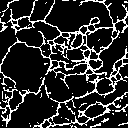

In [23]:
to_pil((output[0][0].cpu()>0).float())

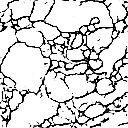

In [24]:
to_pil(F.sigmoid(output[0][1].cpu()))

In [ ]:
def showw(object, i):
    imgs = object[i].cpu()
    img = F.sigmoid(imgs[2][1])
    return to_pil(img)

In [25]:
list_inp = []
list_out = []
for i, data in enumerate(test_loader):
    input = data
    input = input.to(device)
    test_output = model(input)
    list_inp.append(input)
    list_out.append(test_output)

In [29]:
from PIL import ImageSequence
index = 3 
for i in range(len(list_out)):
    test_out = showw(list_out, i)
    test_out.save("../r_unet/data/test_output/frame%d.png" % index)
    index += 1